In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
import os
import copy

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import skimage.io 
import skimage.segmentation

In [2]:
train = os.listdir('train')

len(train)

586

In [3]:
test = os.listdir('test')
len(test)

87

In [4]:
import glob
import pandas as pd
pd.set_option('display.max_colwidth', -1)  
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['animation.html'] = 'jshtml'
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

import pydicom

<ipython-input-4-b4cd77b5885a>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


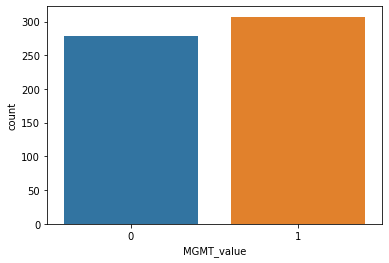

In [5]:
df = pd.read_csv('train_labels.csv')

sns.countplot(data=df, x='MGMT_value');

In [6]:
# Add the full paths for each id for different types of sequences to the csv 
def full_ids(data):
    zeros = 5 - len(str(data))
    if zeros > 0:
        prefix = ''.join(['0' for i in range(zeros)])
    
    return prefix+str(data)

In [7]:
df['BraTS21ID_full'] = df['BraTS21ID'].apply(full_ids)

# Add all the paths to the df for easy access
df['flair'] = df['BraTS21ID_full'].apply(lambda file_id : 'train/'+file_id+'/FLAIR/')
df['t1w'] = df['BraTS21ID_full'].apply(lambda file_id : 'train/'+file_id+'/T1w/')
df['t1wce'] = df['BraTS21ID_full'].apply(lambda file_id : 'train/'+file_id+'/T1wCE/')
df['t2w'] = df['BraTS21ID_full'].apply(lambda file_id : 'train/'+file_id+'/T2w/')
df

BraTS21ID  MGMT_value BraTS21ID_full               flair  \
0    0          1           00000          train/00000/FLAIR/   
1    2          1           00002          train/00002/FLAIR/   
2    3          0           00003          train/00003/FLAIR/   
3    5          1           00005          train/00005/FLAIR/   
4    6          1           00006          train/00006/FLAIR/   
..  ..         ..             ...                         ...   
580  1005       1           01005          train/01005/FLAIR/   
581  1007       1           01007          train/01007/FLAIR/   
582  1008       1           01008          train/01008/FLAIR/   
583  1009       0           01009          train/01009/FLAIR/   
584  1010       0           01010          train/01010/FLAIR/   

                  t1w               t1wce               t2w  
0    train/00000/T1w/  train/00000/T1wCE/  train/00000/T2w/  
1    train/00002/T1w/  train/00002/T1wCE/  train/00002/T2w/  
2    train/00003/T1w/  train/00003/T1wCE/  train/00003/T2w/  
3    train/00005/T1w/  train/00005/T1wCE/  train/00005/T2w/  
4    train/00006/T1w/  train/00006/T1wCE/  train/00006/T2w/  
..                ...                 ...               ...  
580  train/01005/T1w/  train/01005/T1wCE/  train/01005/T2w/  
581  train/01007/T1w/  train/01007/T1wCE/  train/01007/T2w/  
582  train/01008/T1w/  train/01008/T1wCE/  train/01008/T2w/  
583  train/01009/T1w/  train/01009/T1wCE/  train/01009/T2w/  
584  train/01010/T1w/  train/01010/T1wCE/  train/01010/T2w/  

[585 rows x 7 columns]

In [8]:
data = pydicom.dcmread('train/00000/T1w/Image-24.dcm')
data

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.42955106407039211039170882102206590655
(0008, 0050) Accession Number                    SH: '00000'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'T1w'
(0010, 0010) Patient's Name                      PN: '00000'
(0010, 0020) Patient ID                          LO: '00000'
(0018, 0023) MR Acquisition Type                 CS: '2D'
(0018, 0050) Slice Thickness                     DS: '5.0'
(0018, 0081) Echo Time                           DS: None
(0018, 0083) N

In [9]:
def get_image(data):
    '''
    Returns the image data as a numpy array.
    '''  
    if np.max(data.pixel_array)==0:
        img = data.pixel_array
    else:
        img = data.pixel_array/np.max(data.pixel_array)
        img = (img * 255).astype(np.uint8)
        
    return img

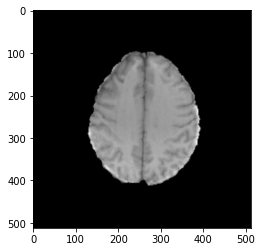

In [10]:
data = pydicom.dcmread('train/00000/T1w/Image-24.dcm')
img = get_image(data)
plt.imshow(img, cmap='gray');

In [11]:
def sorted_image_dirs(path: str):
    '''
    Sorts the list of image directories by image number in a path
    '''
    dirs = glob.glob(path+'*')
    dirs.sort(key=lambda x: int(x.split('/')[-1].split('-')[-1].split('.')[0]))
    
    return dirs

In [12]:
def get_all_images(path: str):
    '''
    Returns a list of (non blank) images from a given path (of shape [non_blank_image_count, 512, 512])
    '''
    image_dirs = sorted_image_dirs(path)
    images = []
    
    for dir in image_dirs:
        data = pydicom.dcmread(dir)
        img = get_image(data)
        
        # Exclude the blank images
        if np.max(img)!=0:
            images.append(img)
        else:
            pass
    
    return images

In [13]:
    
def show_animation(images: list):
    '''
    Displays an animation from the list of images.
    
    set: matplotlib.rcParams['animation.html'] = 'jshtml'
    
    '''
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(images[0], cmap='gray')
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]
    
    return matplotlib.animation.FuncAnimation(fig, animate_func, frames = len(images), interval = 20)

No of images: 74
MGMT:  0


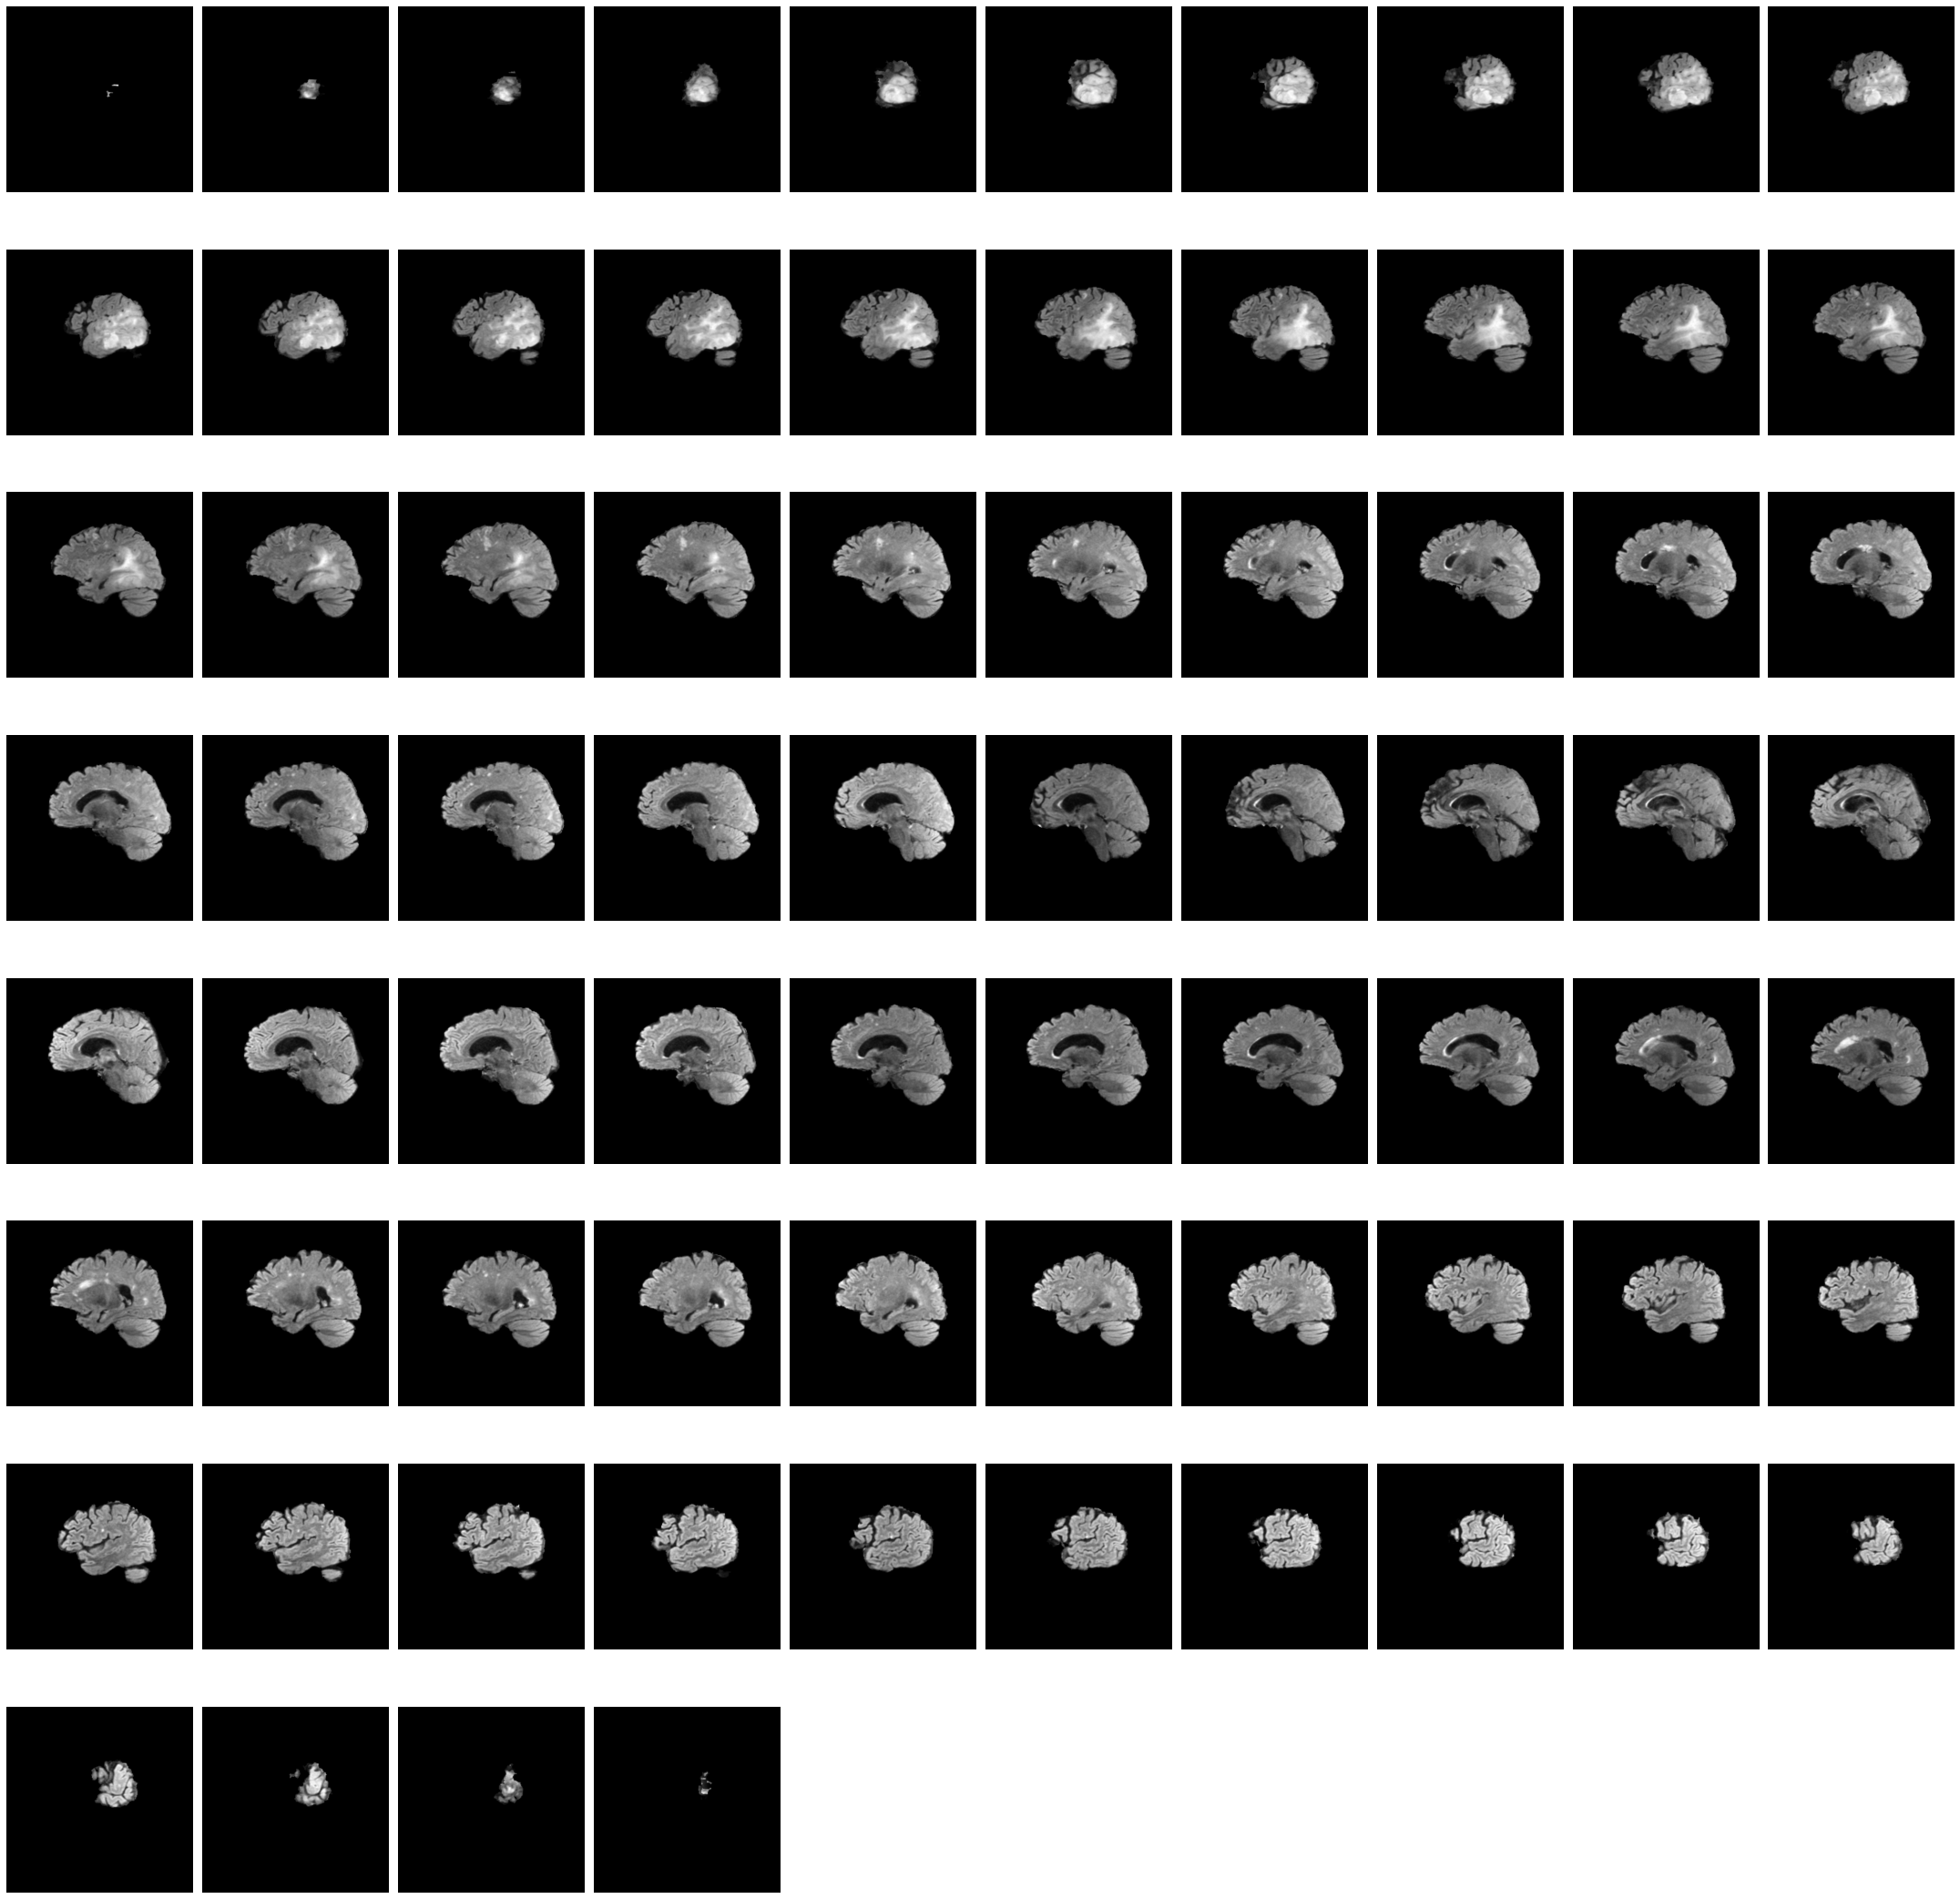

In [14]:
# A random patient - patient 10
patient = 10

flair_images = get_all_images(df['flair'][patient])
print('No of images:', len(flair_images))
print('MGMT: ', df['MGMT_value'][patient])

fig = plt.figure(figsize=(30,30))

c = 1
for image in flair_images:
    ax = fig.add_subplot(len(flair_images)//10+1, 10, c)
    ax.imshow(image, cmap='gray')
    c+=1
    
    plt.axis('off')
    
fig.tight_layout()

No of images: 74


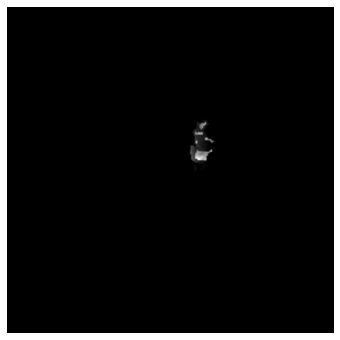

In [15]:
print('No of images:', len(flair_images))

flair_animation = show_animation(flair_images)
flair_animation

No of images: 28


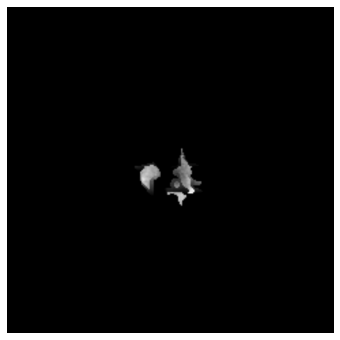

In [16]:
t1w_images = get_all_images(df['t1w'][patient])
    
print('No of images:', len(t1w_images))
show_animation(t1w_images)

In [17]:
# https://www.kaggle.com/davidbroberts/determining-mr-image-planes
def get_image_plane(data):
    '''
    Returns the MRI's plane from the dicom data.
    
    '''
    x1,y1,_,x2,y2,_ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1,y1,x2,y2]

    if cords == [1,0,0,0]:
        return 'coronal'
    if cords == [1,0,0,1]:
        return 'axial'
    if cords == [0,1,0,0]:
        return 'sagittal'

In [18]:
def get_middle_image(path: str, plane=False):
    '''
    Returns the middle image from the path
    
    if plane=True returns the plane
    '''
    image_dirs = sorted_image_dirs(path)

    dicom = pydicom.dcmread(image_dirs[len(image_dirs)//2])
    img = get_image(dicom)
    plane = get_image_plane(dicom)
    
    if plane:
        return img, plane
    else:
        return img

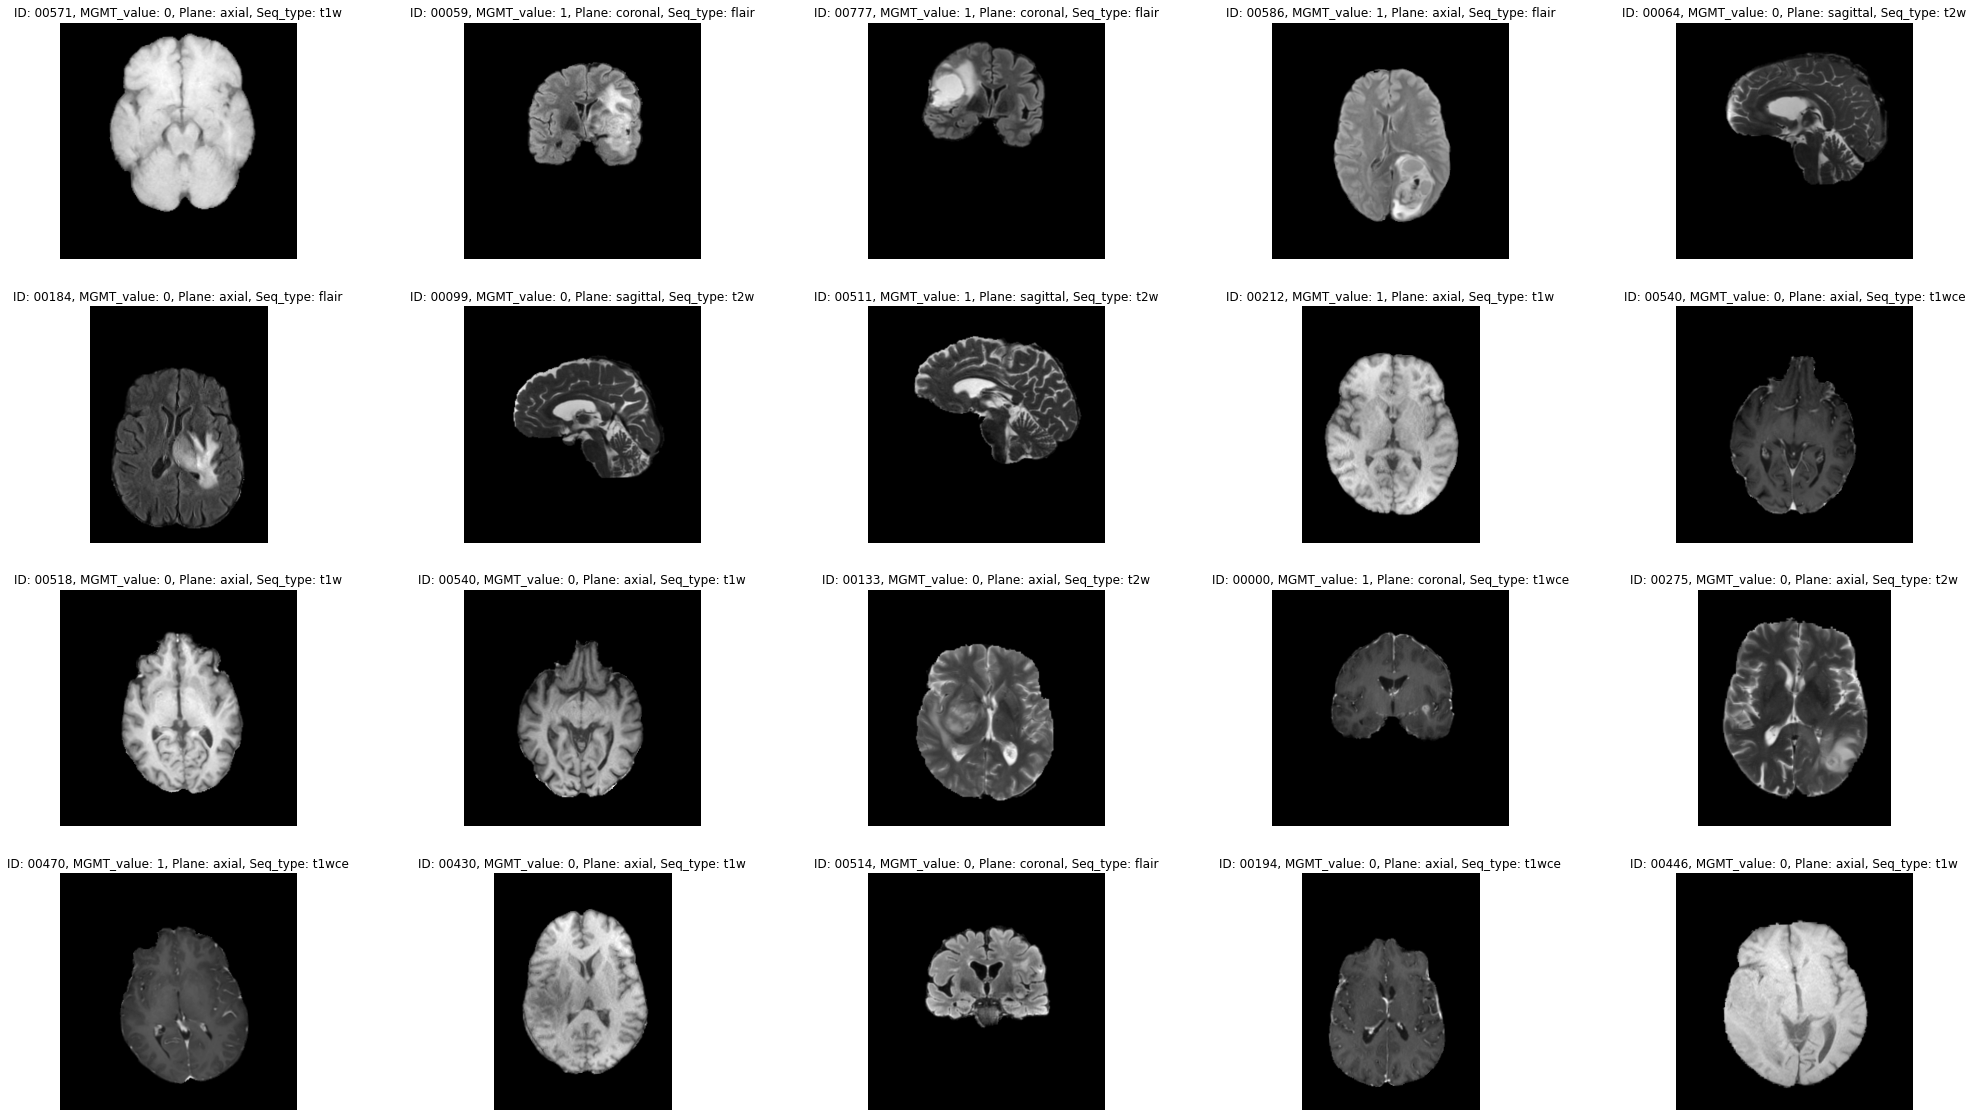

In [19]:
fig = plt.figure(figsize=(35,20))

seq_types = ['flair', 't1w', 't1wce', 't2w']

for i in range(20):
    
    patient = np.random.randint(low=0, high=len(df))
    seq_type = np.random.choice(seq_types)

    # path for the randomly selected image and sequence type
    seq_path = df[seq_type][patient]

    # Get the middle image and plane from the path
    img, plane = get_middle_image(seq_path, plane=True)
    
    patient_id, mgmt = df['BraTS21ID_full'][patient], df['MGMT_value'][patient]
    
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(img, cmap='gray')
    plt.title(f'ID: {patient_id}, MGMT_value: {mgmt}, Plane: {plane}, Seq_type: {seq_type}')
    plt.axis('off')

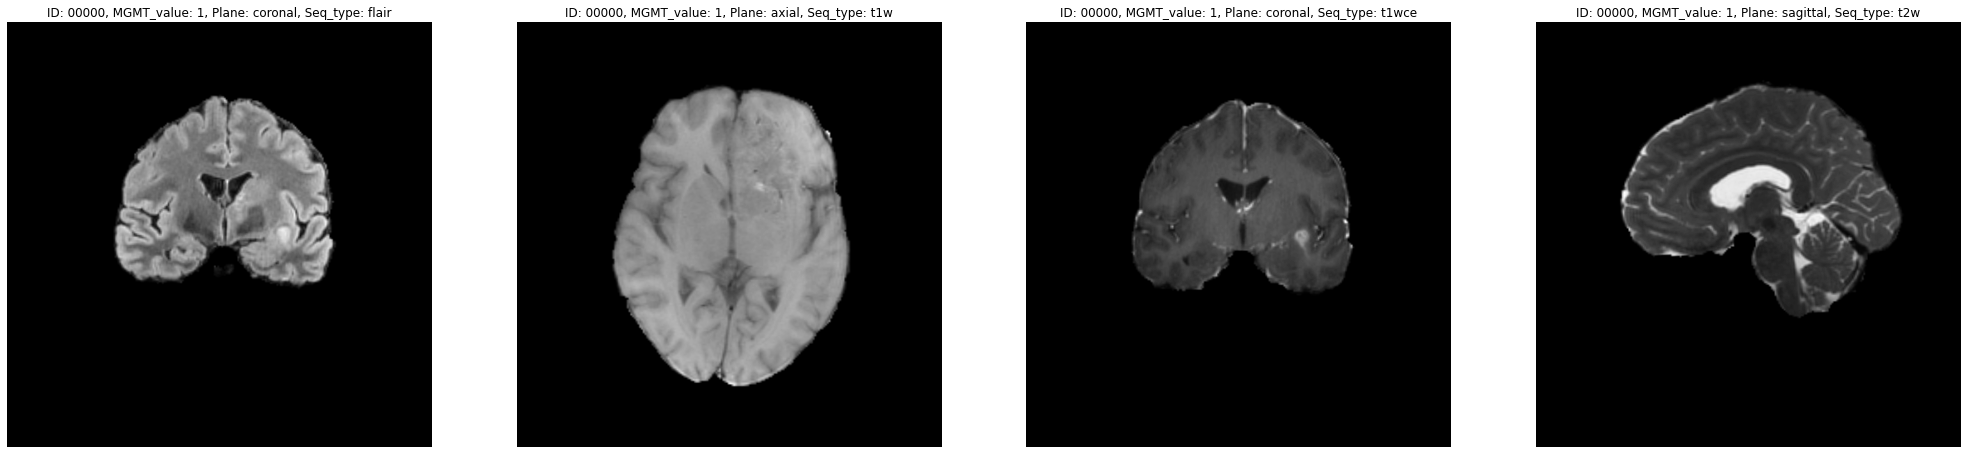

In [20]:
fig = plt.figure(figsize=(35,20))

seq_types = ['flair', 't1w', 't1wce', 't2w']

patient = 0  # The first patient

for i in range(4):
    
    seq_type = seq_types[i]
    seq_path = df[seq_type][patient]

    # Get the middle image and plane from the path
    img, plane = get_middle_image(seq_path, plane=True)
    
    patient_id, mgmt= df['BraTS21ID_full'][patient], df['MGMT_value'][patient]
    
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(img, cmap='gray')
    plt.title(f'ID: {patient_id}, MGMT_value: {mgmt}, Plane: {plane}, Seq_type: {seq_type}')
    plt.axis('off')

In [21]:
seq_types = ['flair', 't1w', 't1wce', 't2w']

seq_axes = {'flair':[], 't1w':[], 't1wce':[], 't2w':[]}

for index in tqdm(range(len(df))):
    
    for seq in seq_types:
        
        seq_path = df[seq][index]

        # Get the middle image from the path
        img, plane = get_middle_image(seq_path, plane=True)
    
        seq_axes[seq].append(plane)
        
# Add the axes to the dataframe
df['flair_axis'] = seq_axes['flair']
df['t1w_axis'] = seq_axes['t1w']
df['t1wce_axis'] = seq_axes['t1wce']
df['t2w_axis'] = seq_axes['t2w']

# Print the axes with the respective patient ID
df[['BraTS21ID_full', 'flair_axis', 't1w_axis', 't1wce_axis', 't2w_axis']]

100%|██████████| 585/585 [00:08<00:00, 71.32it/s]


BraTS21ID_full flair_axis t1w_axis t1wce_axis  t2w_axis
0    00000          coronal    axial    coronal    sagittal
1    00002          sagittal   axial    coronal    sagittal
2    00003          sagittal   axial    coronal    sagittal
3    00005          coronal    axial    coronal    sagittal
4    00006          axial      axial    coronal    sagittal
..     ...            ...        ...        ...         ...
580  01005          axial      axial    axial      axial   
581  01007          axial      axial    axial      axial   
582  01008          axial      axial    axial      axial   
583  01009          axial      axial    axial      axial   
584  01010          axial      axial    axial      axial   

[585 rows x 5 columns]

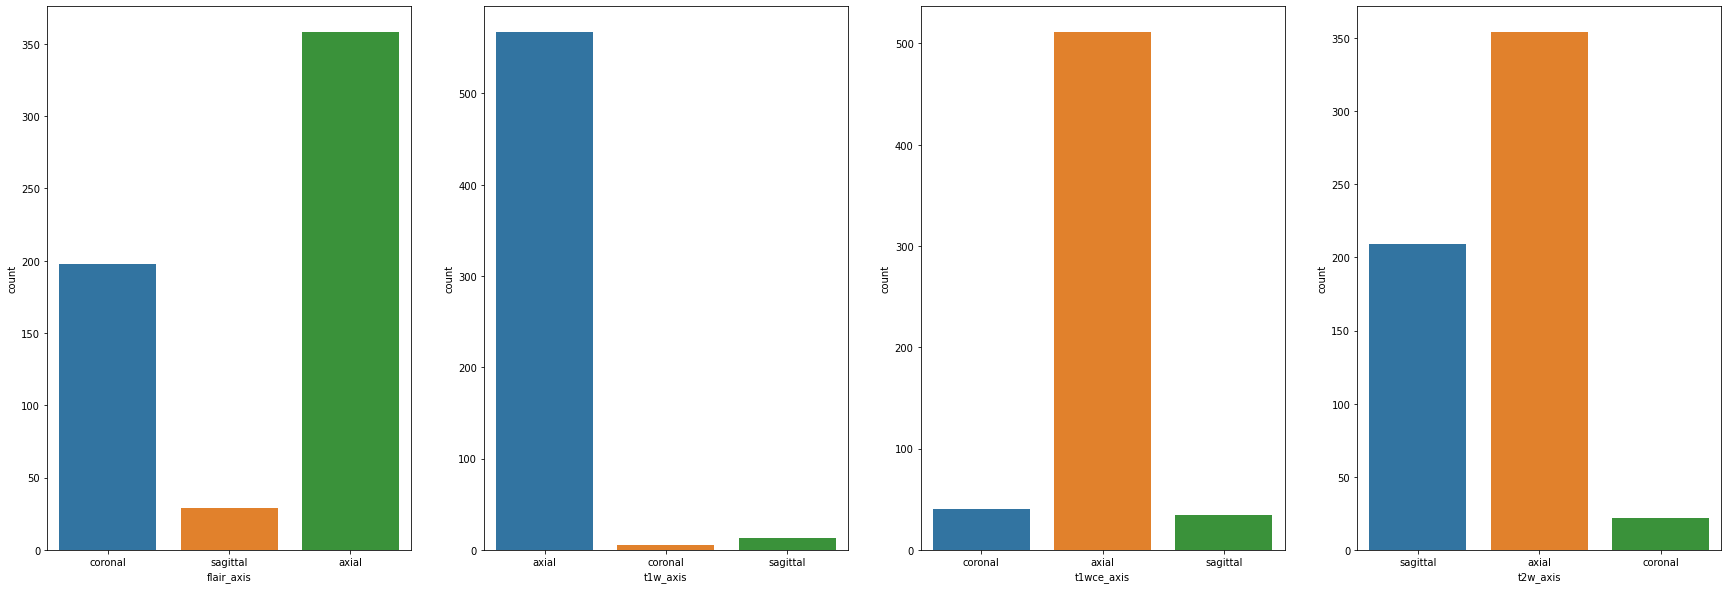

In [22]:
fig, ax = plt.subplots(1,4, figsize=(30,10))

sns.countplot(x='flair_axis', data=df, ax=ax[0])
sns.countplot(x='t1w_axis', data=df, ax=ax[1])
sns.countplot(x='t1wce_axis', data=df, ax=ax[2])
sns.countplot(x='t2w_axis', data=df, ax=ax[3])

plt.show()

In [23]:
to_exclude = [109, 123, 709]

df = df[~df['BraTS21ID'].isin(to_exclude)]

In [24]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import GlorotNormal

# this configuration uses backend.set_image_data_format('channels_first')

"""
This design creates the same network than before but using the layer by layer configuration.
Notice the Input layer and each layer description.
Function returns a model which require inputs and outputs (could be multiple of each one)
"""
def get_model_design(filters: list, input_shape: tuple) -> Model:
    input_layer = Input(shape=input_shape)

    conv1_layer = Convolution2D(filters[0], (5, 5), padding='same', kernel_regularizer=l2(0.001), activation=relu)(input_layer)
    conv2_layer = Convolution2D(filters[1], (3, 3), padding='same', kernel_regularizer=l2(0.001), activation=relu)(conv1_layer)
    maxpool1_layer = MaxPool2D(pool_size=(2, 2))(conv2_layer)
    norm1_layer = BatchNormalization()(maxpool1_layer)

    flat1_layer = Flatten()(norm1_layer)
    drop1_layer = Dropout(0.5)(flat1_layer)
    pred_layer = Dense(1, kernel_initializer=GlorotNormal(), activation=sigmoid)(drop1_layer)

    model = Model(inputs=input_layer, outputs=pred_layer)
    return model

# for this example, we used 128 and 64 filters for the two first conv layers
# note the input size of 3 channel for an image size of 64x64 pixels
model = get_model_design([128, 64], (3, 64, 64))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 64, 64)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 64, 128)        204928    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 64, 64)         73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 32, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 32, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

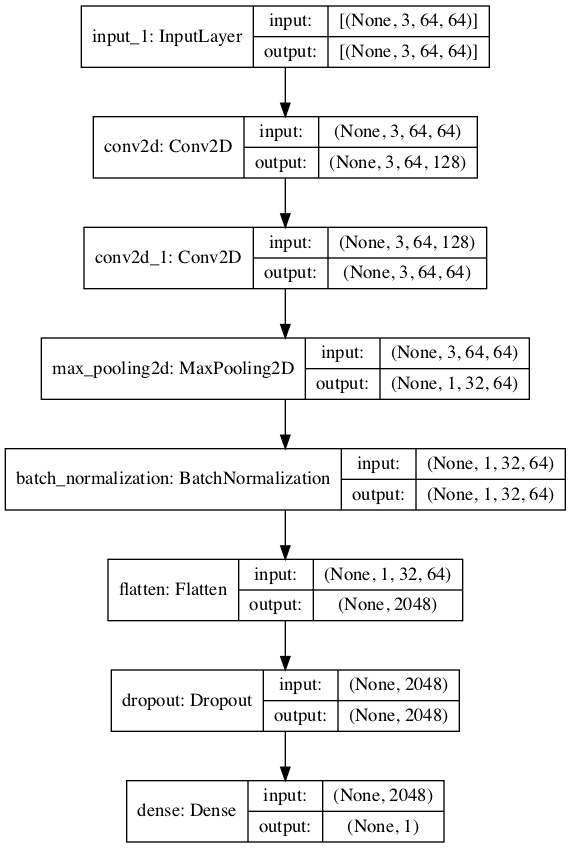

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'my-CNNmodel.png', show_shapes=True)

In [27]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity

"""
Definition of metrics commonly used on medical imaging classification, segmentation, and localization problems.
The metrics will appear on each iteration of the training process to monitor the progress of our design.
"""
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity'),
]

"""
For example, the loss function is to determine is an image contains or not a lesion/disease using the binary cross-entropy loss.
The optimizer is a first-order gradient-based optimization
"""
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(lr=1e-3, beta_1=0.92, beta_2=0.999),
              metrics=METRICS)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

"""
This callback will stop the training when there is no improvement in the validation accuracy across epochs
"""
early_callback = EarlyStopping(monitor='val_auc', 
                               verbose=1,
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

In [30]:
df.head()

BraTS21ID  MGMT_value BraTS21ID_full               flair               t1w  \
0  0          1           00000          train/00000/FLAIR/  train/00000/T1w/   
1  2          1           00002          train/00002/FLAIR/  train/00002/T1w/   
2  3          0           00003          train/00003/FLAIR/  train/00003/T1w/   
3  5          1           00005          train/00005/FLAIR/  train/00005/T1w/   
4  6          1           00006          train/00006/FLAIR/  train/00006/T1w/   

                t1wce               t2w flair_axis t1w_axis t1wce_axis  \
0  train/00000/T1wCE/  train/00000/T2w/  coronal    axial    coronal     
1  train/00002/T1wCE/  train/00002/T2w/  sagittal   axial    coronal     
2  train/00003/T1wCE/  train/00003/T2w/  sagittal   axial    coronal     
3  train/00005/T1wCE/  train/00005/T2w/  coronal    axial    coronal     
4  train/00006/T1wCE/  train/00006/T2w/  axial      axial    coronal     

   t2w_axis  
0  sagittal  
1  sagittal  
2  sagittal  
3  sagittal  
4  sagittal

In [31]:
X = df.drop(['BraTS21ID', 'MGMT_value'], axis=1)
y = df['MGMT_value']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [36]:
batch_size = 64

"""
Training the model for 60 epochs using our dataset.
The batch size (64) is the same for the validation data.
Only 1 callback was used, but could be more like TensorBoard, ModelCheckpoint, etc.
"""
history = model.fit(X_train,
                    y_train,
                    epochs=60,
                    validation_data=[X_test, y_test],
                    callbacks=[early_callback])
model.save('model_base')

Epoch 1/60


ValueError: in user code:

    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/kyledufrane/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 3, 64, 64), found shape=(None, 9)
